In [1]:
import numpy as np
import torch
from temperature_scaling import _ECELoss
from visualize import *
from calibration import *
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

NUM_BINS = 10
N = 10000 # takes value from 1 to 10000
NUM_CLASSES =  100
NUM_CLASSES_PLOT = 100
NUM_COL = 10
METHOD_NAME = "binary_isotonic_regression"

In [2]:
# Load prediction from ResNet on CIFAR100 test data, which contains 10,000 images. 
# https://github.com/rloganiv/pytorch-classification/blob/master/predict.py
# data: a numpy array of size 10,000 * 101. For each row, the first entry is the true label,
#       following by softmax of output logits of this image for each class.
data = np.genfromtxt("data/cifar100_predictions_dropout.txt")[0:N,:]# 10000*101

In [3]:
p = data[:,1:]
Y_predict = np.argmax(p, axis=1)
Y_true = data[:,0]

# Fit isotonic regression to each class

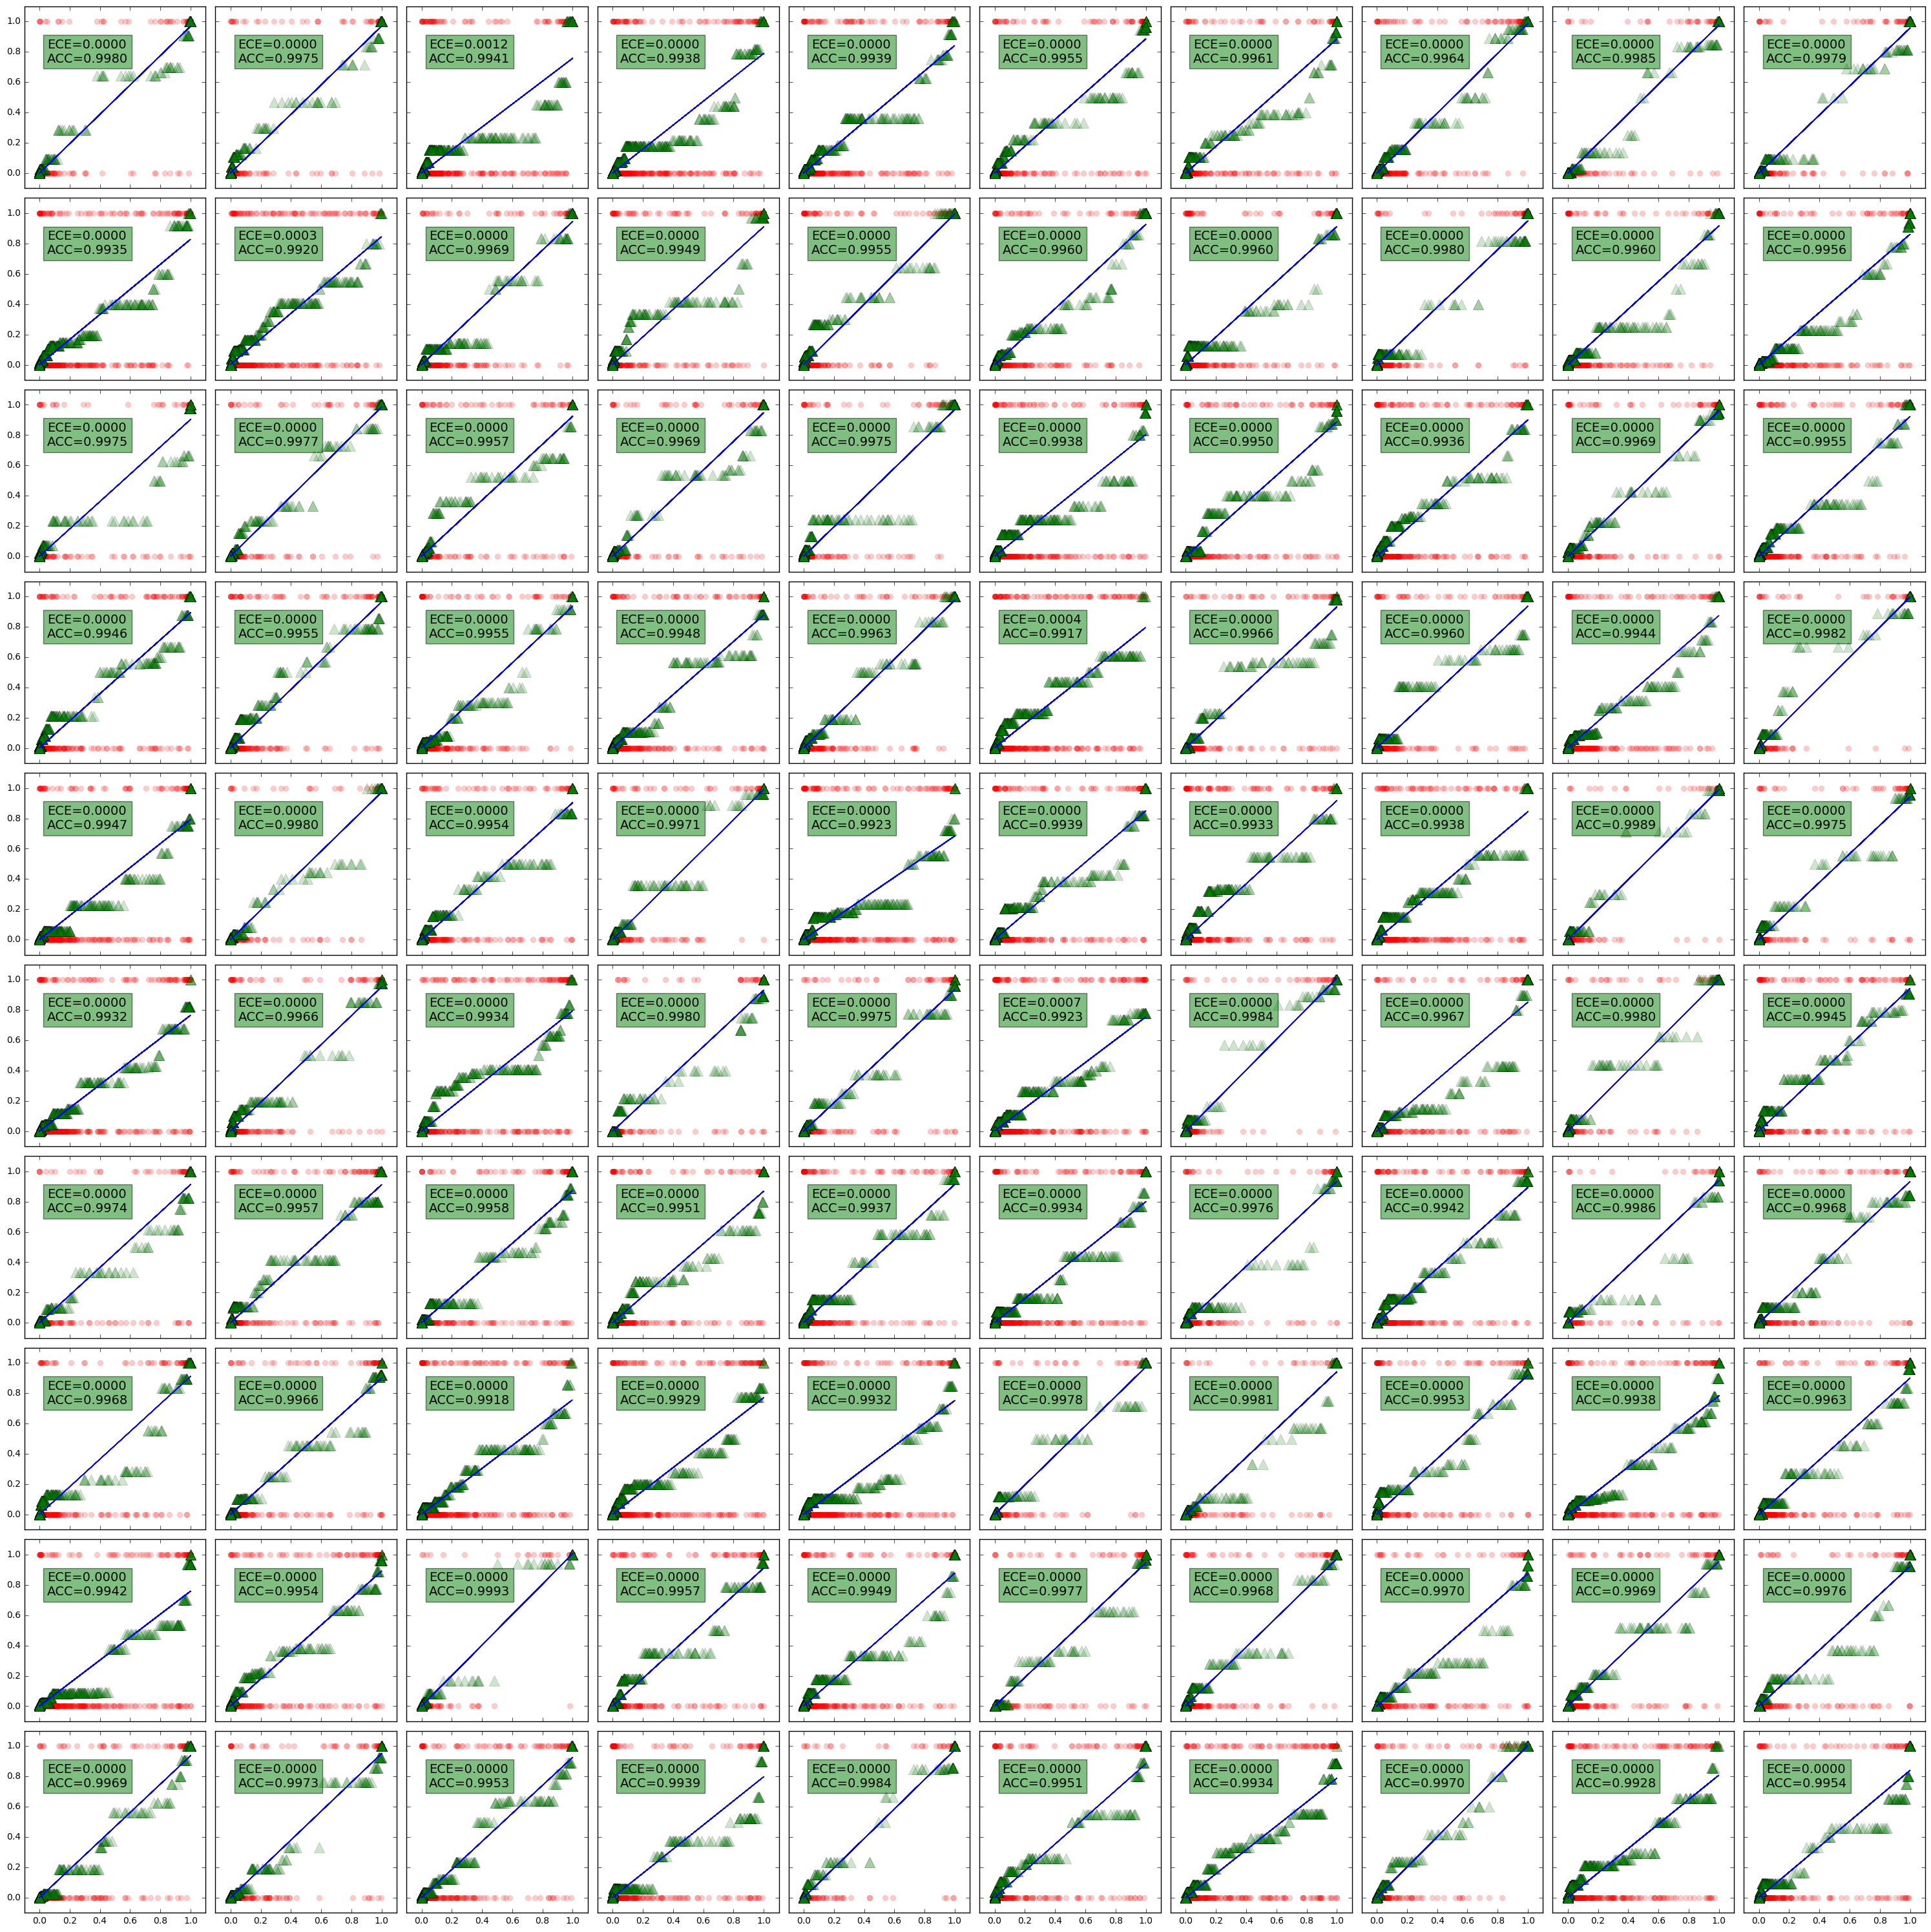

In [4]:
f, ax = plt.subplots(NUM_CLASSES_PLOT/NUM_COL, NUM_COL, sharex='col', sharey='row')
f.set_figheight(30)
f.set_figwidth(30)
for K in range(NUM_CLASSES_PLOT):
    ax[K/NUM_COL, K%NUM_COL] = isotonic_regression(\
                                ax[K/NUM_COL, K%NUM_COL],
                                p[:,K],
                                np.array((Y_true == K)) * 1)
f.tight_layout()
f.savefig("figures/%s/reliability_per_class.png" % METHOD_NAME)
f.savefig("figures/%s/reliability_per_class.eps" % METHOD_NAME, format='eps',dpi=1000)
#plt.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='lower right')

# Calibrate predictions

In [5]:
ece = dict()
acc = dict()

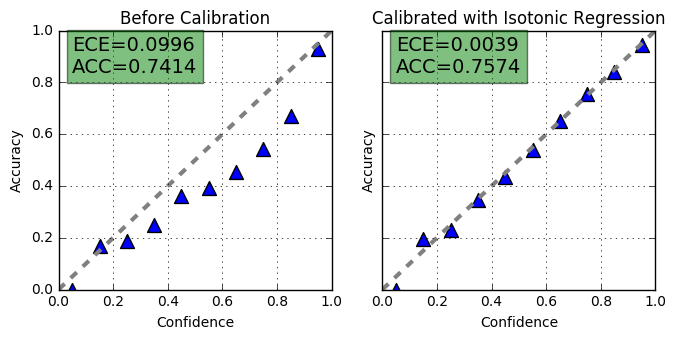

In [6]:
p_calibrated = isotonic_calibration(p, Y_true, p)

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize = (7, 3.5))
ece[0], acc[0], axs[0] = reliability_plot(axs[0], p, Y_true, NUM_BINS)
ece[N], acc[N], axs[1] = reliability_plot(axs[1], p_calibrated, Y_true, NUM_BINS)
axs[0].set_title("Before Calibration")
axs[1].set_title("Calibrated with Isotonic Regression")
fig.tight_layout()
fig.savefig("figures/%s/binary_isotonic_reliability.png" % METHOD_NAME)

# Calibration with different sizes of calibration set

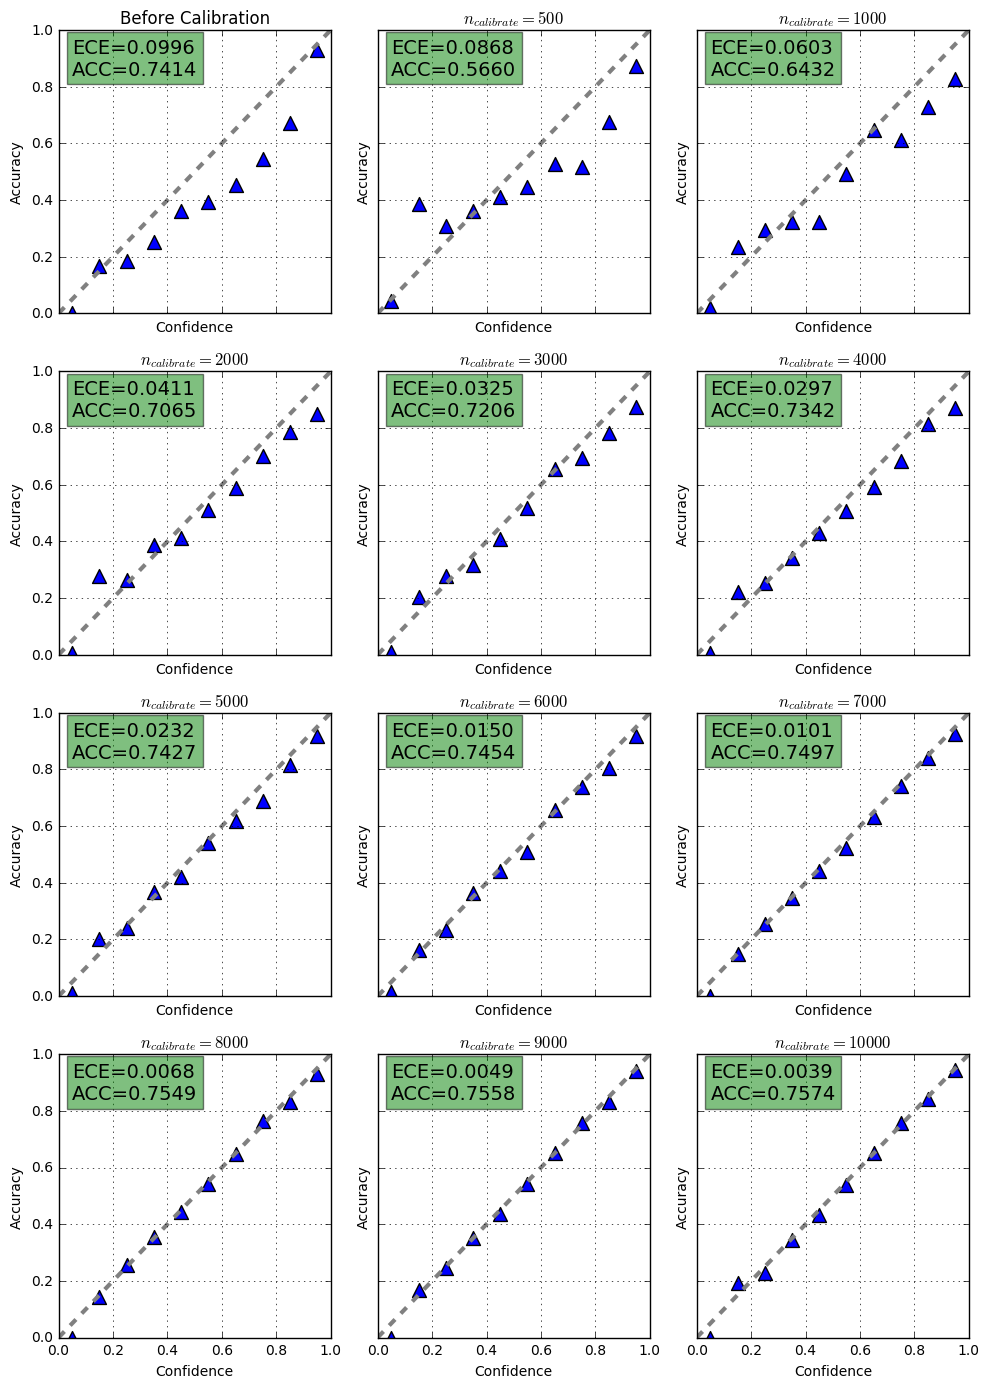

In [7]:
N_range = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
fig, axs = plt.subplots(nrows=(len(N_range)+2)/3, ncols=3, sharey=True, sharex = True, 
                        figsize = (10, 14))

ece[0], acc[0], axs[0,0] = reliability_plot(axs[0][0], p, Y_true, NUM_BINS)
axs[0,0].set_title("Before Calibration")

for i in range(len(N_range)):
    idx = np.random.choice(N, size=N_range[i], replace = False)
    p_calibrated = isotonic_calibration(p[idx,:], Y_true[idx], p)
    ece[N_range[i]],acc[N_range[i]],axs[(i+1)/3,(i+1)%3] = \
            reliability_plot(axs[(i+1)/3,(i+1)%3], p_calibrated, Y_true, NUM_BINS)
    axs[(i+1)/3,(i+1)%3].set_title("$n_{calibrate}=%d$" % N_range[i])
fig.tight_layout()
fig.savefig("figures/%s/calibration_size_reliability.png" % METHOD_NAME)

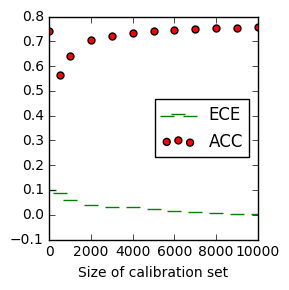

In [11]:
plt.figure(figsize=(3,3))
x, y = zip(*sorted(ece.items()))
plt.scatter(x, y, marker="_", s = 100, c = 'g')
x, y = zip(*sorted(acc.items()))
plt.scatter(x, y, marker=".", s = 100, c = 'r')
plt.xlim(0,10000)
plt.legend(('ECE', 'ACC'), loc='center right')
plt.xlabel("Size of calibration set")
plt.tight_layout()
plt.savefig("figures/%s/ACC_vs_ECE.png" % METHOD_NAME)